In [205]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
from statsmodels.formula.api import ols

import geopandas as gpd

import dython

In [172]:
relative_dir = "../data/curated/"
properties = pd.read_csv(relative_dir + "properties_processed.csv", index_col=0)
income = pd.read_csv("../data/raw/external/vic_income.csv", index_col=0)
mapping = pd.read_csv("../data/raw/external/sa2_postcode_map.csv", index_col=0)
distances = pd.read_csv(relative_dir + "all_distances.csv", index_col=0)

In [174]:
distances = distances.drop(['cbd_distance', 'station_distance'], axis=1)

In [175]:
properties['Postcode'] = properties['Postcode'].astype(str)

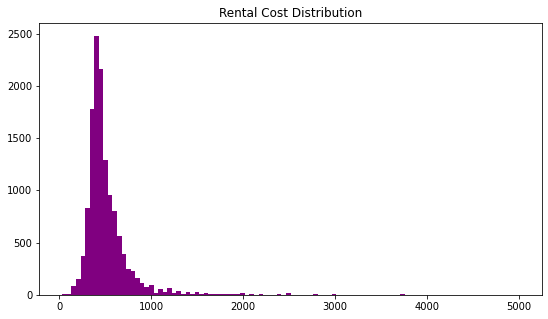

In [158]:
# Rental Cost Distribution
plt.figure(figsize = (9, 5))
plt.title('Rental Cost Distribution')
plt.hist(properties['Cost'], bins=100, color='purple')
plt.savefig('../plots/cost_distribution.jpg')
plt.show()

In [176]:
mapping['POSTCODE'] = mapping['POSTCODE'].astype(str)

In [177]:
properties = pd.merge(properties, mapping, left_on='Postcode', right_on='POSTCODE').drop('POSTCODE', axis=1)

In [178]:
properties['SA2_MAINCODE_2011'] = properties['SA2_MAINCODE_2011'].astype(str)
properties = properties.rename({'SA2_MAINCODE_2011':'SA2'})

In [179]:
properties = properties.merge(distances, on='Name')

## Income Data

In [180]:
income['SA2'] = income['SA2'].astype(str)
income.head()

,SA2,SA2_name,Earners,Median_age,Sum,Median
579,201011001,Alfredton,7989,42,508645842,53932
580,201011002,Ballarat,7595,47,591465895,53688
581,201011003,Ballarat - North,13598,43,820866354,50593
582,201011004,Ballarat - South,12722,40,646001740,45828
583,201011005,Buninyong,4249,46,268782250,52377


In [181]:
properties['SA2_MAINCODE_2011'] = properties['SA2_MAINCODE_2011'].astype(float).astype(int).astype(str)
properties = pd.merge(properties, income, left_on='SA2_MAINCODE_2011', right_on='SA2')
properties.head(1)

,Name,Cost,Coordinates,Bed,Bath,Parking,Property_Type,Agency,Postcode,SA2_MAINCODE_2011,...,station_duration,ptv_1,ptv_2,ptv_3,SA2,SA2_name,Earners,Median_age,Sum,Median
0,4/180 Little Collins Street Melbourne VIC 3000,500.0,"[-37.8138601, 144.9679067]",1,1,0,Apartment / Unit / Flat,Dingle Partners,3000,206041122,...,163.9,144.953239,157.017325,166.748476,206041122,Melbourne,27182,30,1426389488,30024


*Note:* We treat the ordinal features as continuous in order to keep ordering information.

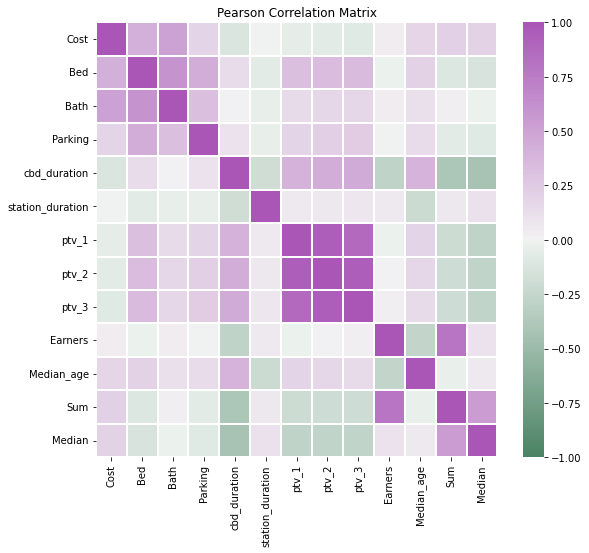

In [220]:
corrmat = properties.corr(method='pearson')
f, ax = plt.subplots(figsize =(9, 8))
colours = sns.diverging_palette(145, 300, s=60, as_cmap=True)
# possible colours: "coolwarm", "vlag"
sns.heatmap(corrmat, ax = ax, cmap=colours, linewidths = 0.1, center=0, vmin=-1)
plt.title('Pearson Correlation Matrix')
plt.savefig('../plots/correlation.jpg')
plt.show()

Find the most correlated features with rental cost of property.

In [254]:
sorted_mat = corrmat.unstack().sort_values()

df = pd.DataFrame(data=sorted_mat)
df.rename({0:'correlation'}, axis=1, inplace=True)
df['Index'] = df.index
df = pd.concat(
        [df.drop('Index', axis=1), 
        df['Index'].apply(pd.Series)]
    , axis=1)
cost_correlations = pd.DataFrame(df[df[0] == 'Cost']['correlation'])
cost_correlations['abs_corr'] = abs(cost_correlations['correlation'])
cost_correlations.sort_values(by='abs_corr', ascending=False)

correlation  abs_corr
Cost Cost                 1.000000  1.000000
     Bath                 0.511271  0.511271
     Bed                  0.414702  0.414702
     Sum                  0.211490  0.211490
     Median               0.197999  0.197999
     Parking              0.192691  0.192691
     Median_age           0.183651  0.183651
     cbd_duration        -0.119682  0.119682
     ptv_3               -0.079777  0.079777
     ptv_2               -0.063327  0.063327
     ptv_1               -0.052333  0.052333
     Earners              0.034916  0.034916
     station_duration    -0.005090  0.005090

In [253]:
# # get correlation of numeric attributes with cost
# corr_data = properties#[['Cost', 'Bed', 'Bath', 'Parking', 'Property_Type', 'Agency', 'Earners', 'Median_age', 'Sum', 'Median']]
# corrmat = dython.nominal.associations(corr_data, annot=False, plot=False)
# corr = corrmat['corr']
# sorted = dython.nominal.cluster_correlations(corr)
# dython.nominal.associations(sorted, annot=False, title='Correlation Matrix')

In [109]:
# test for relationship with categorical variables using one-way ANOVA
categoricals = ['Postcode', 'Property_Type', 'Agency']

for c in categoricals:
    model = ols('Cost ~ '+c, data = properties).fit() # Oridnary least squares
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

               df        sum_sq        mean_sq         F  PR(>F)
Postcode    374.0  2.019698e+08  540026.239923  9.126862     0.0
Residual  11465.0  6.783713e+08   59168.884891       NaN     NaN
                    df        sum_sq       mean_sq         F        PR(>F)
Property_Type      9.0  3.375730e+07  3.750811e+06  52.41311  5.539890e-94
Residual       11830.0  8.465838e+08  7.156245e+04       NaN           NaN
               df        sum_sq        mean_sq         F  PR(>F)
Agency     1335.0  3.347445e+08  250744.959848  4.827422     0.0
Residual  10504.0  5.455966e+08   51941.789567       NaN     NaN


All p values are less than 0.05 so all attributes are significant.